In [ ]:
import sys
import numpy as np
from main import dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd


In [58]:
def features_extraction(dataloader, session_type):
    samples = list(dataloader)
    data = []

    for sample in tqdm(samples, desc="Extracting coords & labels"):
        session = sample[session_type]  
        if session is not None:
            player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])  
            player_coords = player_coords[:, [0, 2]]  # Keep only x and z

            if player_coords.shape[0] > 29999:
                player_coords = player_coords[:29999] 

            questionnaire_data = sample["questionnaire"]
            score_sum = None
            if questionnaire_data is not None:
                score_sum = sum(int(questionnaire_data[f"asrs{i}"]) for i in range(1, 19) if f"asrs{i}" in questionnaire_data)

            data.append({"id": sample.num_id, "label": score_sum, "trajectory": player_coords,})

    return pd.DataFrame(data)

def plot_trajectory(trajectory, line_color='red', line_width=2, figsize=(8, 6)):
    """
    Trace une seule trajectoire dans un notebook Jupyter avec une mise à l'échelle appropriée.

    Args:
        trajectory (np.array): Tableau de forme (nb_timestamps, 2) contenant les coordonnées de la trajectoire.
        line_color (str): Couleur de la ligne de la trajectoire (par défaut 'red').
        line_width (int): Épaisseur de la ligne de la trajectoire (par défaut 2).
        figsize (tuple): Taille de la figure (largeur, hauteur) (par défaut (8, 6)).
    """
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.plot(x, y, color=line_color, linewidth=line_width, markersize=5)

    ax.set_xlim([x.min() - 10, x.max() + 10])
    ax.set_ylim([y.min() - 10, y.max() + 10])

    ax.set_xlabel('Coordonnée X')
    ax.set_ylabel('Coordonnée Y')
    ax.set_title('Trajectoire')

    ax.grid(True)

    plt.show()
    
def plot_trajectories(df_1, df_2, line_color_1 = 'black', line_color_2 = 'red', line_width = 1, figsize=(8, 6)):
    """
    Trace deux groupes de trajectoires de couleur différentes.

    Args:
        df_1 (pd.DataFrame): DataFrame contenant les trajectoires du premier groupe.
        df_2 (pd.DataFrame): DataFrame contenant les trajectoires du second groupe.
        line_color_1 (str): Couleur de la ligne du premier groupe (par défaut 'black').
        line_color_2 (str): Couleur de la ligne du second groupe (par défaut 'red').
        line_width (int): Épaisseur de la ligne de la trajectoire (par défaut 1).
        figsize (tuple): Taille de la figure (largeur, hauteur) (par défaut (8, 6)).
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()

    for i, row in df_1.iterrows():
        trajectory = row['trajectory']
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        ax.plot(x, y, color=line_color_1, linewidth=line_width, alpha=0.5)

    for i, row in df_2.iterrows():
        trajectory = row['trajectory']
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        ax.plot(x, y, color=line_color_2, linewidth=line_width, alpha=0.5)

    x_min = min(df_1['trajectory'].apply(lambda x: x[:, 0].min()).min(), df_2['trajectory'].apply(lambda x: x[:, 0].min()).min())
    x_max = max(df_1['trajectory'].apply(lambda x: x[:, 0].max()).max(), df_2['trajectory'].apply(lambda x: x[:, 0].max()).max())
    y_min = min(df_1['trajectory'].apply(lambda x: x[:, 1].min()).min(), df_2['trajectory'].apply(lambda x: x[:, 1].min()).min())
    y_max = max(df_1['trajectory'].apply(lambda x: x[:, 1].max()).max(), df_2['trajectory'].apply(lambda x: x[:, 1].max()).max())
    ax.set_xlim([x_min - 10, x_max + 10])
    ax.set_ylim([y_min - 10, y_max + 10])
    
    ax.set_xlabel('Coordonnée X')
    ax.set_ylabel('Coordonnée Y')
    ax.set_title('Trajectoires')
    
    ax.grid(True)
    plt.show()
    
def reduce_number_of_points(extraction, n_points):
    """
    Réduit le nombre de points dans une extraction de trajectoires.
    
    Args:
        extraction (pd.DataFrame): Extraction de trajectoires.
        n_points (int): Nombre de points à conserver.
        
    Returns:
        pd.DataFrame: Extraction de trajectoires avec un nombre de points réduit.
    """
    data = []
    for _, row in tqdm(extraction.iterrows()):
        trajectory = row['trajectory']
        if len(trajectory) > n_points:
            indices = np.linspace(0, len(trajectory) - 1, n_points, dtype=int)
            reduced_trajectory = trajectory[indices]
        else:
            reduced_trajectory = trajectory
        data.append({"id": row['id'], "label": row['label'], "trajectory": reduced_trajectory})
    return pd.DataFrame(data)

def transform_trajectories_to_long_format(df, output_file, trajectory_column='trajectory', id_column='id'):
    """
    Transforme un DataFrame de trajectoires en un format long et enregistre le résultat en CSV.

    Args:
        output_file (str): Nom du fichier CSV de sortie (par défaut 'trajectories_long.csv').
        df (pd.DataFrame): DataFrame contenant les trajectoires.
        trajectory_column (str): Nom de la colonne contenant les trajectoires (numpy arrays).
        id_column (str): Nom de la colonne contenant les identifiants des individus.

    Returns:
        pd.DataFrame: DataFrame au format long avec les colonnes 'id', 'x', 'y'.
    """
    long_data = []

    for idx, row in df.iterrows():
        individual_id = row[id_column]
        
        trajectory = row[trajectory_column]
        
        if not isinstance(trajectory, np.ndarray) or trajectory.shape[1] != 2:
            raise ValueError(f"La trajectoire de l'individu {individual_id} n'est pas un numpy array de forme (nb_timestamps, 2).")
        
        for point in trajectory:
            x, y = point
            long_data.append({
                'id': individual_id,
                'x': x,
                'y': y
            })

    long_df = pd.DataFrame(long_data)
    
    long_df.to_csv(output_file, index=False)
    print(f"Le DataFrame a été enregistré dans le fichier {output_file}")
    
    return long_df

def transform_long_to_trajectories(df, id_column='idx', x_column='location.lat', y_column='location.long', trajectory_column='trajectory'):
    """
    Transforme un DataFrame au format long en un DataFrame de trajectoires compact.

    Args:
        df (pd.DataFrame): DataFrame au format long avec les colonnes 'id', 'x', 'y'.
        id_column (str): Nom de la colonne contenant les identifiants des individus.
        x_column (str): Nom de la colonne contenant les coordonnées x.
        y_column (str): Nom de la colonne contenant les coordonnées y.
        trajectory_column (str): Nom de la colonne à créer pour stocker les trajectoires.

    Returns:
        pd.DataFrame: DataFrame au format compact avec les colonnes 'id' et 'trajectory'.
    """
    trajectories_dict = {}

    for idx, row in df.iterrows():
        individual_id = row[id_column]
        x = row[x_column]
        y = row[y_column]
        
        if individual_id not in trajectories_dict:
            trajectories_dict[individual_id] = []
        
        trajectories_dict[individual_id].append([x, y])

    compact_data = []
    for individual_id, trajectory in trajectories_dict.items():
        compact_data.append({
            id_column: individual_id,
            trajectory_column: np.array(trajectory)  # Convertir en np array
        })

    compact_df = pd.DataFrame(compact_data)
    
    return compact_df


In [59]:
df_extraction_uniform = features_extraction(dataloader, "uniform")
df_extraction_patchy = features_extraction(dataloader, "patchy")
df_reduced_uniform = reduce_number_of_points(df_extraction_uniform, 400)
df_reduced_patchy = reduce_number_of_points(df_extraction_patchy, 400)

Extracting coords & labels: 100%|██████████| 39/39 [00:22<00:00,  1.70it/s]
39it [00:00, 1833.61it/s]
38it [00:00, 6424.42it/s]


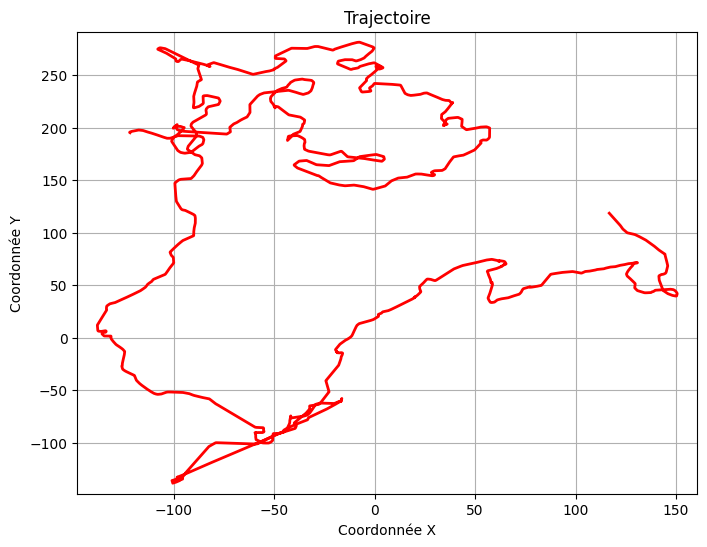

In [ ]:
plot_trajectory(df_extraction_uniform.iloc[0]["trajectory"])

In [61]:
transform_trajectories_to_long_format(df_reduced_uniform, 'uniform_400.csv')
transform_trajectories_to_long_format(df_reduced_patchy, 'patchy_400.csv')

Le DataFrame a été enregistré dans le fichier uniform_400.csv
Le DataFrame a été enregistré dans le fichier patchy_400.csv


,id,x,y
0,29,-121.653000,195.311996
1,29,-121.658539,195.315689
2,29,-121.658539,195.315689
3,29,-120.430534,193.827103
4,29,-117.153923,188.912766
...,...,...,...
15195,21,53.720154,-18.037836
15196,21,55.530579,-18.683290
15197,21,56.456619,-24.135345
15198,21,52.084587,-27.919611


In [38]:
GENERATED_TRAJECTORIES_PATH = Path.cwd().parent.parent/"generated_trajectories"
df_generated_patchy_10 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=10_0_k0_patchy_400.csv')
df_generated_patchy_90 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=90_0_k0_patchy_400.csv')
df_generated_patchy_200 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=200_0_k0_patchy_400.csv')
df_generated_patchy_10 = transform_long_to_trajectories(df_generated_patchy_10)
df_generated_patchy_90 = transform_long_to_trajectories(df_generated_patchy_90)
df_generated_patchy_200 = transform_long_to_trajectories(df_generated_patchy_200)

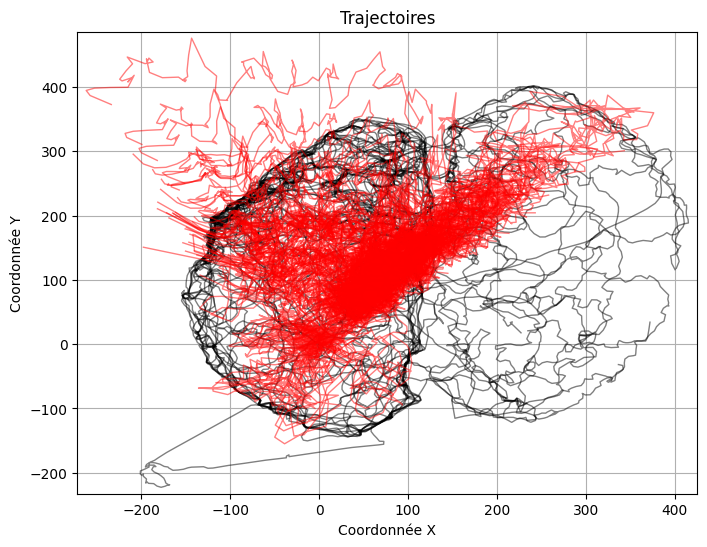

In [47]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_10)

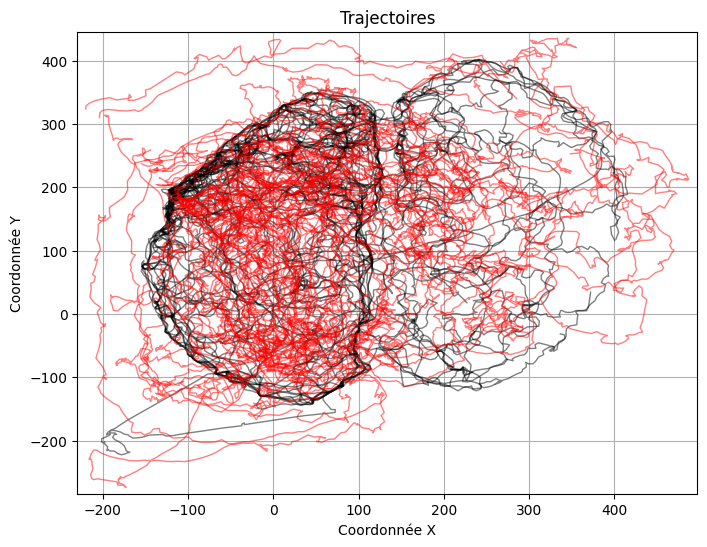

In [48]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_90)

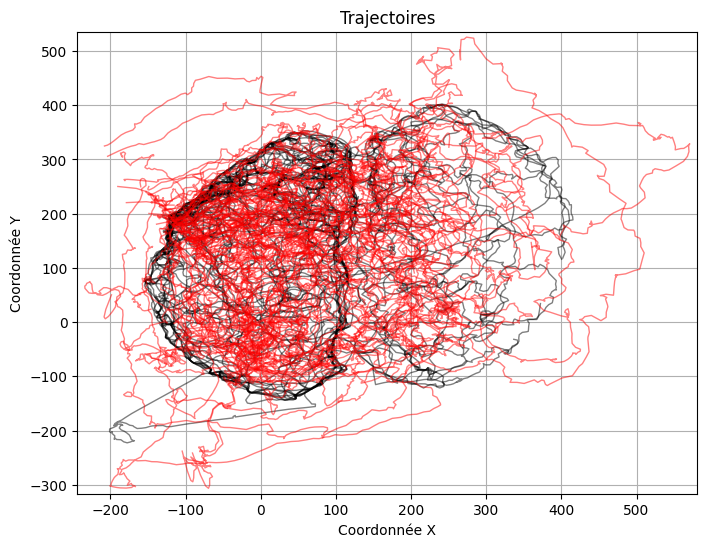

In [49]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_200)